<a href="https://colab.research.google.com/github/DEli-26/DS_Practicum/blob/main/15_churn/2210_pract_fin_proj_churn_v_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6><b>**Проект Я.Практикум (Выпускной)**</b></font>
    
<font size=6><b>**Отток клиентов в Ниединогоразрыва.ком**</b></font>

***

# Постановка задачи

**Заказчик**  
Оператор связи Ниединогоразрыва.ком.

**Цель**  
Построить модель машинного обучения для прогнозирования оттока клиентов. 
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Построенная модель должна обладать метрикой ROC AUC не менее 0,88.

**Задачи**  

1. Загрузить данные и собрать в один датафрейм;
1. Провести анализ распределения данных, аномалий и пропусков;
1. Определить степень корреляции признаков и оптимизировать их состав;
1. Разделить данные на обучающую и тестовую выборки, провести обучение модели логистической регрессии (ЛР) в качестве Baseline;
1. Подобрать гиперпараметры модели DescisionTree (DT) для достижения максимального значения метрики ROC AUC;
1. Подобрать гиперпараметры модели Catboost (CB) для достижения максимального значения метрики ROC AUC;
1. Проанализировать наиболее важные признаки для модели, провести их оптимизацию и провести повторное обучение модели;
1. Сделать выводы.

**Исходные данные**  
Персональные данные о некоторых клиентах, информация об их тарифах и договорах актуальны на 1 февраля 2020 и содержатся в файлах: 

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Оператор предоставляет два основных типа услуг: 

1. Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Доступны дополнительные услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

# Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import re
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

from tqdm.notebook import tqdm

try:
    import optuna
except Exception:
    ! pip install optuna
    import optuna

try:
    import phik
except Exception:
    !pip install phik
    import phik

try:
    from catboost import CatBoostClassifier, Pool, cv
except Exception:
    !pip install catboost
    from catboost import CatBoostClassifier, Pool, cv

try:
    import shap
except Exception:
    !pip install shap
    import shap

shap.initjs()

# Темная тема графиков
plt.style.use("dark_background")

# отображение таблиц без ограничения на количество столбцов:
pd.set_option("display.max_columns", None)

# автоформатирование
%load_ext lab_black

Загрузим сами данные.

In [ ]:
try:
    contract = pd.read_csv("D:\Jupyter\practicum_17\contract.csv")
    internet = pd.read_csv("D:\Jupyter\practicum_17\internet.csv")
    personal = pd.read_csv("D:\Jupyter\practicum_17\personal.csv")
    phone = pd.read_csv("D:\Jupyter\practicum_17\phone.csv")
except FileNotFoundError:
    contract = pd.read_csv("/datasets/final_provider/contract.csv")
    internet = pd.read_csv("/datasets/final_provider/internet.csv")
    personal = pd.read_csv("/datasets/final_provider/personal.csv")
    phone = pd.read_csv("/datasets/final_provider/phone.csv")

# Exploratory Data Analysis

## Обзор данных

Вызовем первые 5 строк, общую информацию о таблице, а также количество дубликатов.

In [ ]:
def first_look(df):
    display(df.head())
    print(df.info())
    print(f"Количество дубликатов: {df.duplicated().sum()}")

In [ ]:
first_look(contract)

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
Количество дубликатов: 0


In [ ]:
first_look(internet)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
Количество дубликатов: 0


In [ ]:
first_look(personal)

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
Количество дубликатов: 0


In [ ]:
first_look(phone)

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
Количество дубликатов: 0




Из полученной информации хорошо видно, что пропусков в данных нет, как и явных дубликатов.

В то же время данные содержат следующие недостатки:
- Они разделены на 4 таблицы и их следует объединить в один датафрейм для анализа распределений значений, поисков аномалий и построения моделей;
- Признак `TotalCharges` имеет тип `object`, что не соответствует ожидаемому `float`.
- Названия признаков приведено в CamalCase, что можно привести к snake_case. 
Однако оставим их без исправлений, чтобы не вносить путаницу при их обсуждении с заказчиком;
- После объединения таблиц в столбцах значения `Yes/No` следует заменить на числовые `1/0` для упрощения анализа и обучения модели.
Аналогичным образом обработаем столбец `gender`;
- Признак `BeginDate` представляется неинформативным. 
После объединения таблиц его целесообразно заменить на признак `длительность контракта`;
- В датасете отсутствует целевой признак. Для его создания целесообразно использовать столбец `EndDate` таблицы `contract`. 
При наличии даты - признак `1`, отток.

## Обработка данных

### Объединение таблиц

В таблицах содержится разное количество объектов.
Для объединения за основу возьмем `contract`, как наиболее полную.

In [ ]:
df = contract.merge(personal, on="customerID")
df = df.merge(internet, how="left", on="customerID")
df = df.merge(phone, how="left", on="customerID")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Размер таблицы и количество пропусков соответствует данным из разделенных таблиц. 

Образовавшиеся в ходе объединения пропуски заполним значениями `0` для числовых признаков и `no_info` для категориальных. 
Такая замена допустима при создании трех новых признаков с типом клиента - пользующимся только интернетом, только телефоном или обоими сервисами.

После объединения признак `customerID` целесообразно использовать в качестве индекса объектов. 
Это позволит его сохранить для последующего анализа, но не учитывать при моделировании.

In [ ]:
df["internet_user"] = 0
df.loc[df["StreamingMovies"].notnull(), "internet_user"] = 1
df["phone_user"] = 0
df.loc[df["MultipleLines"].notnull(), "phone_user"] = 1
df["phone_n_internet_user"] = 0
df.loc[
    (df["MultipleLines"].notnull()) & (df["StreamingMovies"].notnull()),
    "phone_n_internet_user",
] = 1

In [ ]:
df["InternetService"] = df["InternetService"].fillna("no_info")

df = df.fillna(0)

In [ ]:
df = df.set_index("customerID")

### Обработка строковых значений в столбцах

Значения `Yes/No` и `Female/Male` заменим на числовые `1/0`.

In [ ]:
replaces = {
    "Yes": 1,
    "No": 0,
    "Female": 1,
    "Male": 0,
}

df = df.replace(replaces)

### Исправление типа признака TotalCharges

Исправим тип хранения данных для признака. 
Использование метода `astype` привело к ошибке `could not convert string to float`, что говорит о наличии текстовых символов, которые не могут быть переведены в численное значение.

Отсортируем значения в рассматриваемом столбце.

In [ ]:
df["TotalCharges"].sort_values()

customerID
5709-LVOEQ          
3213-VVOLG          
2520-SGTTA          
3115-CZMZD          
2923-ARZLG          
               ...  
8249-THVEC    997.75
6051-PTVNS     998.1
5899-MQZZL    999.45
4536-PLEQY     999.8
9093-FPDLG     999.9
Name: TotalCharges, Length: 7043, dtype: object

Видно, что в столбце присутствуют объекты с пустыми значениями признака `TotalCharges`.
Выведем такие объекты целиком.

In [ ]:
df[df["TotalCharges"] == " "]

BeginDate EndDate      Type  PaperlessBilling  \
customerID                                                   
4472-LVYGI  2020-02-01       0  Two year                 1   
3115-CZMZD  2020-02-01       0  Two year                 0   
5709-LVOEQ  2020-02-01       0  Two year                 0   
4367-NUYAO  2020-02-01       0  Two year                 0   
1371-DWPAZ  2020-02-01       0  Two year                 0   
7644-OMVMY  2020-02-01       0  Two year                 0   
3213-VVOLG  2020-02-01       0  Two year                 0   
2520-SGTTA  2020-02-01       0  Two year                 0   
2923-ARZLG  2020-02-01       0  One year                 1   
4075-WKNIU  2020-02-01       0  Two year                 0   
2775-SEFEE  2020-02-01       0  Two year                 1   

                        PaymentMethod  MonthlyCharges TotalCharges  gender  \
customerID                                                                   
4472-LVYGI  Bank transfer (automatic)           52.55                    1   
3115-CZMZD               Mailed check           20.25                    0   
5709-LVOEQ               Mailed check           80.85                    1   
4367-NUYAO               Mailed check           25.75                    0   
1371-DWPAZ    Credit card (automatic)           56.05                    1   
7644-OMVMY               Mailed check           19.85                    0   
3213-VVOLG               Mailed check           25.35                    0   
2520-SGTTA               Mailed check           20.00                    1   
2923-ARZLG               Mailed check           19.70                    0   
4075-WKNIU               Mailed check           73.35                    1   
2775-SEFEE  Bank transfer (automatic)           61.90                    0   

            SeniorCitizen  Partner  Dependents InternetService  \
customerID                                                       
4472-LVYGI              0        1           1             DSL   
3115-CZMZD              0        0           1         no_info   
5709-LVOEQ              0        1           1             DSL   
4367-NUYAO              0        1           1         no_info   
1371-DWPAZ              0        1           1             DSL   
7644-OMVMY              0        1           1         no_info   
3213-VVOLG              0        1           1         no_info   
2520-SGTTA              0        1           1         no_info   
2923-ARZLG              0        1           1         no_info   
4075-WKNIU              0        1           1             DSL   
2775-SEFEE              0        0           1             DSL   

            OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
customerID                                                                
4472-LVYGI               1             0                 1            1   
3115-CZMZD               0             0                 0            0   
5709-LVOEQ               1             1                 1            0   
4367-NUYAO               0             0                 0            0   
1371-DWPAZ               1             1                 1            1   
7644-OMVMY               0             0                 0            0   
3213-VVOLG               0             0                 0            0   
2520-SGTTA               0             0                 0            0   
2923-ARZLG               0             0                 0            0   
4075-WKNIU               0             1                 1            1   
2775-SEFEE               1             1                 0            1   

            StreamingTV  StreamingMovies  MultipleLines  internet_user  \
customerID                                                               
4472-LVYGI            1                0              0              1   
3115-CZMZD            0                0              0              0   
5709-LVOEQ            1                1              0     

Из таблицы хорошо видно, что пустые значения соответствуют объектам, дата заключения контракта которых соответствует дате сбора данных.
Таким образом, в их поле `TotalCharges` можно внести значение `0` без искажения смысла. 

In [ ]:
df["TotalCharges"] = df["TotalCharges"].replace(" ", 0)

После выполненных преобразований работает метод `astype`.

In [ ]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

### Добавление целевого признака

Добавим в датасет целевой признак и построим гистограмму его распределения.

In [ ]:
df["churn"] = 0
df.loc[df["EndDate"] != 0, "churn"] = 1

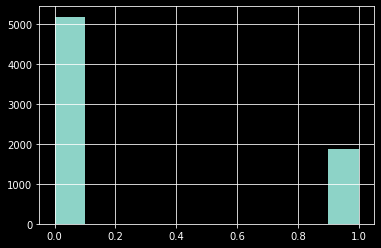

In [ ]:
df["churn"].hist()
plt.show()

In [ ]:
df["churn"].mean()

0.2653698707936959

По полученным данным видно, что присутствует дисбаланс классов и целевой признак `1` соответствует 27% объектам.
Это должно быть учтено при разбиении датасета на подвыборки.

### Добавление признака длительности контракта

Длительность контракта удобно считать в днях.
Для этого сперва заменим нули в столбце `EndDate` на дату получения данных 1 февраля 2020.
Затем следует провести соответствующие преобразования типов хранения даты.

In [ ]:
df["EndDate"] = df["EndDate"].replace(0, "2020-02-01")

In [ ]:
df["BeginDate"] = pd.to_datetime(df["BeginDate"])
df["EndDate"] = pd.to_datetime(df["EndDate"])

In [ ]:
df["duration"] = df["EndDate"] - df["BeginDate"]
df["duration"] = pd.to_numeric(df["duration"]) / 60 / 60 / 24 / 1e9
df["duration"] = df["duration"].astype("int")

Столбцы `BeginDate` и `EndDate` содержат данные о датах и не могут быть использованы в модели линейной регрессии. 
В этой связи их целесообразно исключить из датафрейма.

In [ ]:
df = df.drop(["BeginDate", "EndDate"], axis=1)

Проверим датасет после всех преобразований.

In [ ]:
df.head()

Type  PaperlessBilling              PaymentMethod  \
customerID                                                                
7590-VHVEG  Month-to-month                 1           Electronic check   
5575-GNVDE        One year                 0               Mailed check   
3668-QPYBK  Month-to-month                 1               Mailed check   
7795-CFOCW        One year                 0  Bank transfer (automatic)   
9237-HQITU  Month-to-month                 1           Electronic check   

            MonthlyCharges  TotalCharges  gender  SeniorCitizen  Partner  \
customerID                                                                 
7590-VHVEG           29.85         29.85       1              0        1   
5575-GNVDE           56.95       1889.50       0              0        0   
3668-QPYBK           53.85        108.15       0              0        0   
7795-CFOCW           42.30       1840.75       0              0        0   
9237-HQITU           70.70        151.65       1              0        0   

            Dependents InternetService  OnlineSecurity  OnlineBackup  \
customerID                                                             
7590-VHVEG           0             DSL               0             1   
5575-GNVDE           0             DSL               1             0   
3668-QPYBK           0             DSL               1             1   
7795-CFOCW           0             DSL               1             0   
9237-HQITU           0     Fiber optic               0             0   

            DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
customerID                                                                
7590-VHVEG                 0            0            0                0   
5575-GNVDE                 1            0            0                0   
3668-QPYBK                 0            0            0                0   
7795-CFOCW                 1            1            0                0   
9237-HQITU                 0            0            0                0   

            MultipleLines  internet_user  phone_user  phone_n_internet_user  \
customerID                                                                    
7590-VHVEG              0              1           0                      0   
5575-GNVDE              0              1           1                      1   
3668-QPYBK              0              1           1                      1   
7795-CFOCW              0              1           0                      0   
9237-HQITU              0              1           1                      1   

            churn  duration  
customerID                   
7590-VHVEG      0        31  
5575-GNVDE      0      1036  
3668-QPYBK      1        61  
7795-CFOCW      0      1371  
9237-HQITU      1        61

Произведенная обработка проведена успешно.

## Анализ данных

### ProfileReport

Для анализа воспользуемся библиотекой `pandas_profiling`.

In [ ]:
try:
    from pandas_profiling import ProfileReport
except Exception:
    !pip install pandas_profiling
    from pandas_profiling import ProfileReport

In [ ]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

По приведенным данным можно сделать следующие выводы.

1. Скрытые дубликаты, в виде имеющих одинаковый смысл, но различное написание в категориальных признаках, отсутствуют.
1. Аномалии и выбросы в численных признаках отсутствуют.
1. Самый большой дисбаланс среди оригинальных признаков наблюдается в `SeniorCitizen` и составляет 84%. 
В то же время, признаки `gender` и `Partner` имеют практически равное распределение, что вызывает сомнения в качестве данных.
1. Распределение признака `MonthlyCharges` имеет усиления, что может объясняться наличием популярных дополнительных опций с фиксированной ценой.
1. Распределение признака `duration` также имеет усиления, которые объясняются целыми значениями месяцев и лет.
При использовании в указанном признаке для расчета месяцев возможно сглаживание распределения.
1. Признаки обладают высокой корреляцией как с целевым признаком, так и между собой.
Это ограничивает применение LR из-за ее чувствительности к мультиколлинеарности. 
В то же время модели DT и СВ обладают большей устойчивостью к обнаруженному недостатку датасета.

### Phik

Более детальный анализ корреляции требует построения укрупненного хитмэпа коэффициента корреляции phik с указанием значений самого коэффициента. 

Сначала выведем только значения коэффициента корреляции целевого признака с остальными признаками.

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'internet_user', 'phone_user', 'phone_n_internet_user', 'churn', 'duration']


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


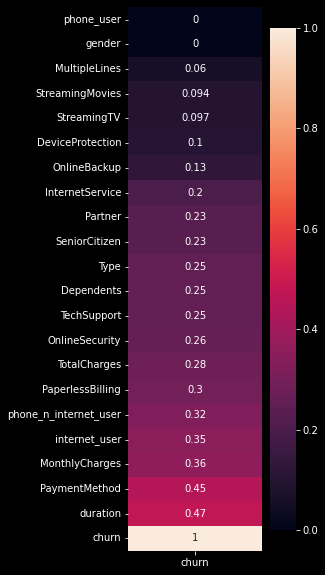

In [ ]:
y = ["churn"]

phik_matrix = df.phik_matrix()

plt.figure(figsize=(3, 10))
sns.heatmap(phik_matrix[y].sort_values(by=y), annot=True)
plt.show()

Из рисунка хорошо видно, что коэффициент корреляции целевого признака с признаками `phone_user` и `gender` равен нулю.
Таким образом, указанные признаки не оказывают вклада в точность решения поставленной задачи и они могут быть безболезненно удалены из рассмотрения.

In [ ]:
phik_matrix = phik_matrix[phik_matrix["churn"] != 0]

phik_matrix = phik_matrix[phik_matrix.index]

Коэффициент корреляции с остальными признаками варьируется от 0,06 до 0,47.
Учитывая, что линейные модели чувствительны к большому количеству признаков, их список целесообразно сократить. 

Построим хитмэп коэффициента корреляции оставшихся признаков друг с другом.
Его анализ может выделить сильно коррелирующие между собой признаки, что станет критерием для их сокращения

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


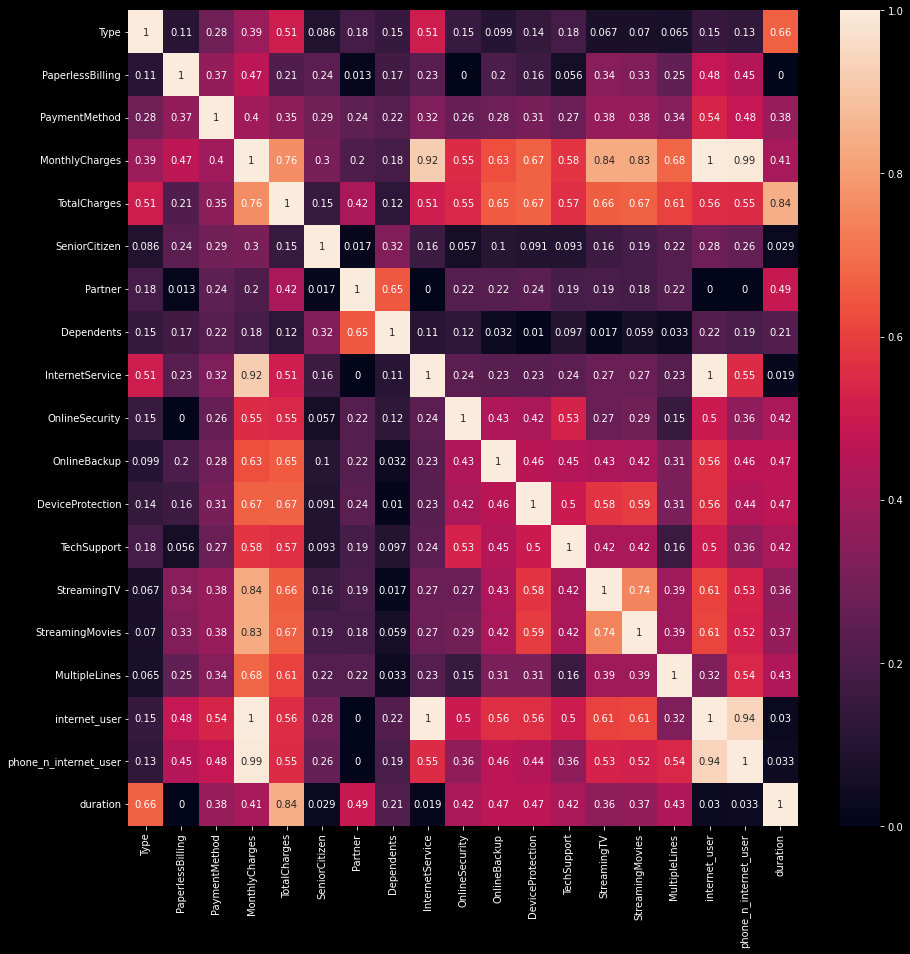

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(phik_matrix.drop(y, axis=0).drop(y, axis=1), annot=True)
plt.show()

Из рисунка видно, что в настоящем датасете имеет место мультиколлинеарность, а коэффициент корреляции для некоторых пар признаков достигает единицы.
Для повышения значения целевой метрики целесообразно исключить признаки с сильной корреляцией.

Рассмотрим более подробно коэффициент корреляции признаков, которые содержались в таблице `internet`.

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


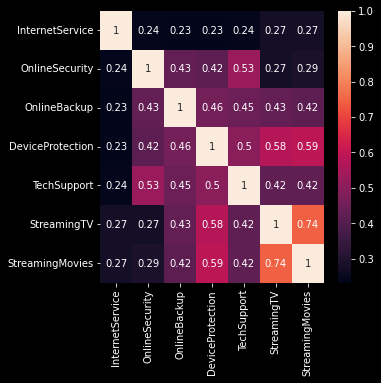

In [ ]:
internet_features = internet.drop(["customerID"], axis=1).columns.tolist()

plt.figure(figsize=(5, 5))
sns.heatmap(
    phik_matrix.loc[internet_features, internet_features],
    annot=True,
)
plt.show()

По рисунку хорошо видно, что все признаки, кроме категориального `InternetService`, сильно коррелируют между собой.
В этой связи представляется целесообразным удаление их всех из перечня признаков для моделирования. 
Однако с целью обобщения и сохранения содержащейся в них информации, сформируем новый признак, который является суммой удаляемых признаков.

In [ ]:
internet_features = internet.drop(
    ["customerID", "InternetService"], axis=1
).columns.tolist()

df["internet_feature"] = df[internet_features].sum(axis=1)

Рассмотрим коэффициент корреляции признаков, которые содержались в таблице `personal`.

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


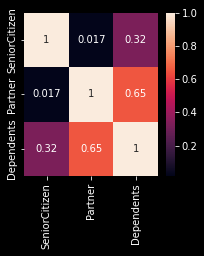

In [ ]:
personal_features = personal.drop(["customerID", "gender"], axis=1).columns.tolist()

plt.figure(figsize=(3, 3))
sns.heatmap(
    phik_matrix.loc[personal_features, personal_features],
    annot=True,
)
plt.show()

Из рисунка виден очевидный факт, что наличие партнера слабо связано с тем, на пенсии человек или нет.
В то же время, если человек на пенсии, у него, вероятно, есть иждивенцы, но более вероятны иждивенцы у тех, у кого есть партнер.
Своеобразная игра "камень-ножницы-бумага".

В этой связи, указанные признаки можно объединить аналогичным признакам об интернет услугах образом.

In [ ]:
df["personal_feature"] = df[personal_features].sum(axis=1)

Обновим матрицу phik и рассмотренные ранее хитмэпы.

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines', 'internet_user', 'phone_n_internet_user', 'churn', 'duration', 'internet_feature', 'personal_feature']


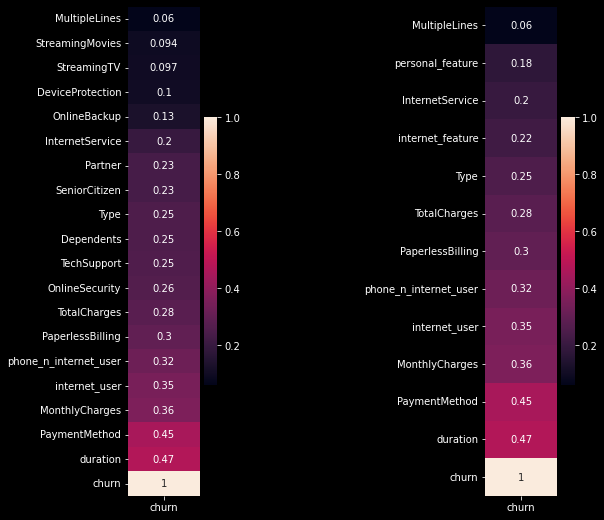

In [ ]:
phik_matrix_cut = df.drop(
    internet_features + personal_features + ["gender", "phone_user"], axis=1
).phik_matrix()

fig = plt.figure(figsize=(8, 9))
gs = gridspec.GridSpec(1, 2, wspace=3)
ax1 = fig.add_subplot(gs[0])
ax1 = sns.heatmap(phik_matrix[y].sort_values(by=y), annot=True)
ax2 = fig.add_subplot(gs[1])
ax2 = sns.heatmap(phik_matrix_cut[y].sort_values(by=y), annot=True)

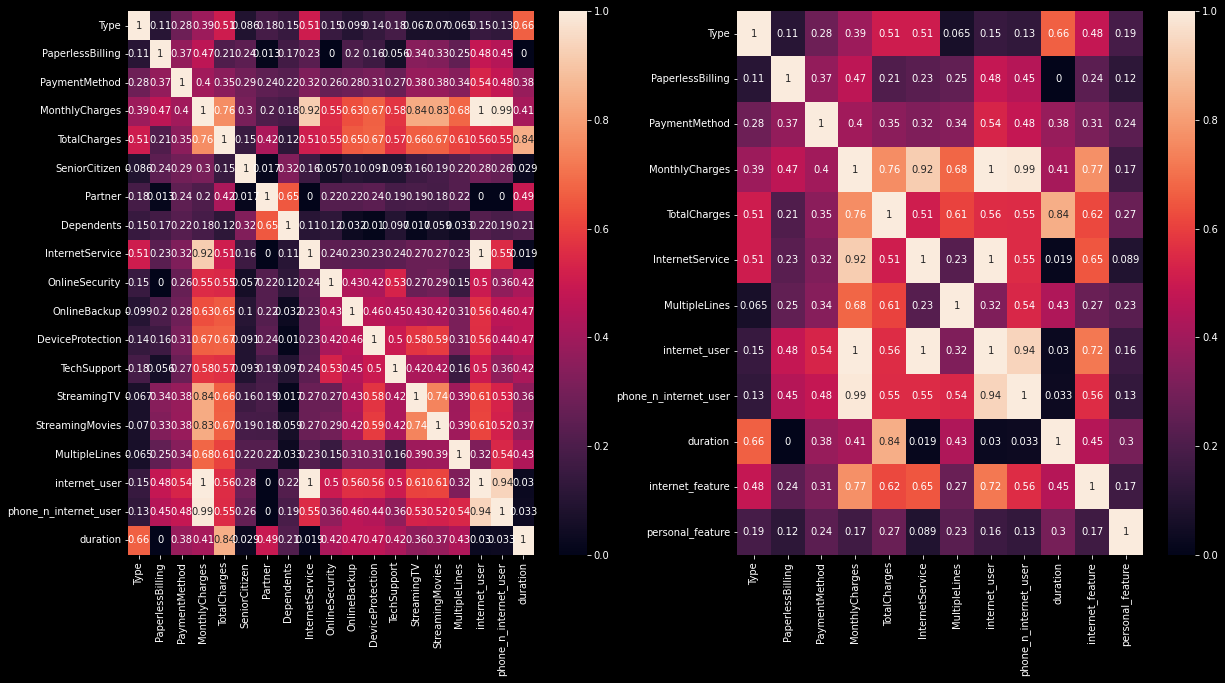

In [ ]:
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0])
ax1 = sns.heatmap(phik_matrix.drop(y, axis=0).drop(y, axis=1), annot=True)
ax2 = fig.add_subplot(gs[1])
ax2 = sns.heatmap(phik_matrix_cut.drop(y, axis=0).drop(y, axis=1), annot=True)

Из рисунков видно, что количество признаков сократилось, однако все еще присутствует мультиколлинеарность.
Критериев для их сокращения на текущем этапе работы нет, в связи с чем указанную операцию проведем по результатам моделирования.

## Заключение по EDA

Проведен обзор данных, в ходе которого определены проблемы, связанные со способами их хранения.
Для их устранения проведена следующая обработка:  
- Таблицы объединены в один датафрейм;
- Строковые значения `Yes/No` в столбцах заменены на `1/0`;
- Исправлены типы хранения данных;
- Добавлен целевой признак и признак о длительности контракта.

В ходе анализа самих данных получено, что все признаки обладают высокой корреляцией как с целевым признаком, так и между собой.
В этой связи исключены из рассмотрения признаки с нулевой корреляцией с целевым признаком, а для признаков из таблиц `internet` и `personal` применена "свертка". 
Последняя получена путем суммирования всех категориальных признаков со значениями `1/0` и формирования нового признака с полученным значением.
Дальнейшую оптимизацию количества признаков целесообразно провести с опорой на результаты моделирования.

# Моделирование

## Подготовка признаков

Перед моделированием объявим переменную, фиксирующую случайные процессы, списки признаков и разделим датасет на обучающую и тестовую подвыборки в пропорции 3:1. 

In [ ]:
SEED = 41022

cat_features = [
    "Type",
    "PaymentMethod",
    "InternetService",
]
num_features = [
    "MonthlyCharges",
    "TotalCharges",
    "duration",
    "internet_feature",
    "personal_feature",
]

train, test = train_test_split(df, test_size=0.25, random_state=41022, stratify=df[y])

Проверим размеры полученных выборок

In [ ]:
train.shape, test.shape

((5282, 24), (1761, 24))

Категориальные признаки закодируем one hot ebcoder'ом, а числовые - стандартизируем.

In [ ]:
def ohe_transformer(df, cat_features, encoder, encoder_columns):
    ohe = encoder.transform(df[cat_features])
    ohe = pd.DataFrame(ohe, columns=encoder_columns, index=df.index)
    ohe = df.drop(cat_features, axis=1).join(ohe)
    return ohe


def ohe(train, test, cat_features):
    encoder = OneHotEncoder(drop="first", sparse=False)
    encoder.fit(train[cat_features])
    encoder_columns = ["_".join(x.split()) for x in encoder.get_feature_names_out()]
    return ohe_transformer(
        train, cat_features, encoder, encoder_columns
    ), ohe_transformer(test, cat_features, encoder, encoder_columns)


def ss(train, test, num_features):
    scaler = StandardScaler()
    scaler.fit(train[num_features])
    train[num_features] = scaler.transform(train[num_features])
    test[num_features] = scaler.transform(test[num_features])
    return train, test

In [ ]:
train_ohe, test_ohe = ohe(train, test, cat_features)

train_ohe_ss, test_ohe_ss = ss(train_ohe, test_ohe, num_features)

Проверим стандартизацию вызовом функции `describe`.

In [ ]:
train_ohe_ss[num_features].describe()

MonthlyCharges  TotalCharges      duration  internet_feature  \
count    5.282000e+03  5.282000e+03  5.282000e+03      5.282000e+03   
mean     8.676639e-17  1.237598e-16  1.076172e-17      1.883301e-17   
std      1.000095e+00  1.000095e+00  1.000095e+00      1.000095e+00   
min     -1.560134e+00 -1.008099e+00 -1.317135e+00     -1.110418e+00   
25%     -9.639666e-01 -8.309402e-01 -9.502557e-01     -1.110418e+00   
50%      1.837277e-01 -3.926221e-01 -1.391187e-01     -2.996706e-02   
75%      8.278716e-01  6.792766e-01  9.588513e-01      5.102583e-01   
max      1.790750e+00  2.810444e+00  1.605893e+00      2.130934e+00   

       personal_feature  
count      5.282000e+03  
mean      -8.474857e-17  
std        1.000095e+00  
min       -1.097531e+00  
25%       -1.097531e+00  
50%        7.030922e-02  
75%        1.238150e+00  
max        2.405990e+00

Среднее значение всех признаков близко к нулю, а СКО - к единице.
Стандартизация удалась.
Оценим ее вклад в целевую метрику.

## Baseline

В качестве baseline предполагалось применить модель LR.
Однако обнаруженная мультиколлинеарность не позволяет ее использовать.
В этой связи, в качестве базовой модели используем модель DT без подбора гиперпараметров.

Объявим перечень используемых признаков.

In [ ]:
X = train_ohe.drop(
    y + internet_features + personal_features + ["gender", "phone_user"], axis=1
).columns.tolist()

X

['PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges',
 'MultipleLines',
 'internet_user',
 'phone_n_internet_user',
 'duration',
 'internet_feature',
 'personal_feature',
 'Type_One_year',
 'Type_Two_year',
 'PaymentMethod_Credit_card_(automatic)',
 'PaymentMethod_Electronic_check',
 'PaymentMethod_Mailed_check',
 'InternetService_Fiber_optic',
 'InternetService_no_info']

Объявим модель и проведем оценку значения метрики при помощи кроссвалидации с фиксированной стратификацей.

In [ ]:
def dt_metrics(params, X):

    model_dt = DecisionTreeClassifier(**params)
    return cross_val_score(
        model_dt, train_ohe_ss[X], train_ohe_ss[y], scoring="roc_auc", cv=skf
    ).mean()

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

params_dt = {
    "random_state": SEED,
    "class_weight": "balanced",
}

dt_metrics(params_dt, X)

0.6884665439808385

Полученный результат меньше заданного условием задачи.

## DecisionTree

Используем библиотеку Optuna и оптимизируем гиперпараметры DT.

In [ ]:
def objective_dt(trial):

    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 3, 50),
        "random_state": SEED,
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 30),
        "class_weight": "balanced",
    }
    model_dt = DecisionTreeClassifier(**params)

    return cross_val_score(
        model_dt, train_ohe_ss[X], train_ohe_ss[y], scoring="roc_auc", cv=skf
    ).mean()

In [ ]:
%%time

study_dt = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_dt.optimize(objective_dt, n_trials=15, show_progress_bar=True)

[I 2022-10-24 22:06:58,642] A new study created in memory with name: no-name-81299721-1434-4dbb-967f-3447468f8ff4
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2022-10-24 22:06:58,772] Trial 0 finished with value: 0.7990004926650559 and parameters: {'criterion': 'gini', 'max_depth': 45, 'max_leaf_nodes': 5}. Best is trial 0 with value: 0.7990004926650559.
[I 2022-10-24 22:06:58,880] Trial 1 finished with value: 0.8469527126714501 and parameters: {'criterion': 'gini', 'max_depth': 45, 'max_leaf_nodes': 27}. Best is trial 1 with value: 0.8469527126714501.
[I 2022-10-24 22:06:58,976] Trial 2 finished with value: 0.8345412220451888 and parameters: {'criterion': 'gini', 'max_depth': 22, 'max_leaf_nodes': 11}. Best is trial 1 with value: 0.8469527126714501.
[I 2022-10-24 22:06:59,082] Trial 3 finished with value: 0.8257963517890555 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_leaf_nodes': 10}. Best is trial 1 with value: 0.8469527126714501.
[I 2022-10-24 22:06:59,185] Trial 4 finished with value: 0.8175465476758264 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'max_leaf_nodes': 6}. Best is trial 1 with value: 0.84695

Обучим модель с полученными гиперпараметрами и проверим значение метрики.

In [ ]:
params_dt = {
    **study_dt.best_params,
    "random_state": SEED,
    "class_weight": "balanced",
}

dt_metrics(params_dt, X)

0.8487864421459232

Получено улучшение значения метрики на 16%.
Тем не менее, оно меньше заданного порога.

Проведем анализ значимости признаков при моделировании при помощи библиотеки Shap.

In [ ]:
def shap_plot(model, df, X):
    explainer_dt = shap.TreeExplainer(model)
    shap_values_dt = explainer_dt.shap_values(df[X])

    shap.summary_plot(shap_values_dt, df[X], plot_size=(15, 8))

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


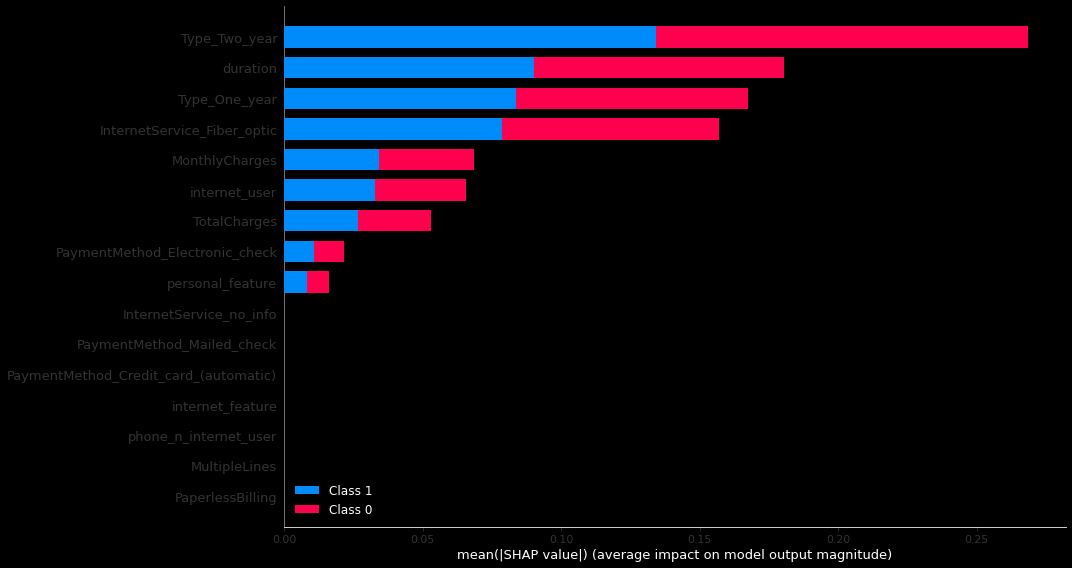

In [ ]:
model_dt = DecisionTreeClassifier(**params_dt)
model_dt.fit(train_ohe_ss[X], train_ohe_ss[y])

shap_plot(model_dt, train_ohe_ss, X)

Из полученного рисунка видно, что только половина признаков используется для предсказания целевого признака.

В этой связи, для уменьшения зашумленности признаков оставим только значимые для модели DT.

In [ ]:
X = [
    "duration",
    "InternetService_Fiber_optic",
    "Type_Two_year",
    "Type_One_year",
    "TotalCharges",
    "internet_user",
    "phone_user",
    "MultipleLines",
    "MonthlyCharges",
]

Проведем подбор гиперпараметров для нового набора признаков.

In [ ]:
study_dt.optimize(objective_dt, n_trials=15, show_progress_bar=True)

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2022-10-24 22:07:01,004] Trial 15 finished with value: 0.8496370493293991 and parameters: {'criterion': 'gini', 'max_depth': 38, 'max_leaf_nodes': 21}. Best is trial 15 with value: 0.8496370493293991.
[I 2022-10-24 22:07:01,103] Trial 16 finished with value: 0.8396946295578068 and parameters: {'criterion': 'gini', 'max_depth': 37, 'max_leaf_nodes': 14}. Best is trial 15 with value: 0.8496370493293991.
[I 2022-10-24 22:07:01,198] Trial 17 finished with value: 0.8500792751796393 and parameters: {'criterion': 'gini', 'max_depth': 39, 'max_leaf_nodes': 22}. Best is trial 17 with value: 0.8500792751796393.
[I 2022-10-24 22:07:01,305] Trial 18 finished with value: 0.8500792751796393 and parameters: {'criterion': 'gini', 'max_depth': 39, 'max_leaf_nodes': 22}. Best is trial 17 with value: 0.8500792751796393.
[I 2022-10-24 22:07:01,404] Trial 19 finished with value: 0.8503529008275723 and parameters: {'criterion': 'gini', 'max_depth': 25, 'max_leaf_nodes': 23}. Best is trial 19 with value: 

In [ ]:
params_dt = {
    **study_dt.best_params,
    "random_state": SEED,
    "class_weight": "balanced",
}

dt_metrics(params_dt, X)

0.8503529008275723

Значение метрики улучшилось на 0,2%, но все еще менее заданного порога.
Перейдем к рассмотрению модели CB.

## CatBoost

Учитывая, что модель СВ строится на алгоритмах RT, представляется целесообразным использовать полученный выше набор признаков.

In [ ]:
X_cb = X.copy()
train_cb = train_ohe_ss.copy()
test_cb = test_ohe_ss.copy()

Оптимизируем гиперпараметры.

In [ ]:
def objective_cb(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1),
        "eval_metric": "Logloss",
        "loss_function": "Logloss",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "depth": trial.suggest_int("depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
        "auto_class_weights": "Balanced",
    }
    model_cb = CatBoostClassifier(**params, verbose=False)

    return cross_val_score(
        model_cb, train_cb[X_cb], train_cb[y], scoring="roc_auc"
    ).mean()

In [ ]:
%%time
study_cb = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_cb.optimize(objective_cb, n_trials=15, show_progress_bar=True)

[I 2022-10-24 22:07:02,585] A new study created in memory with name: no-name-53e23095-a1c5-4be4-8ab1-a40e73b592bd
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2022-10-24 22:07:15,280] Trial 0 finished with value: 0.9178706239943605 and parameters: {'learning_rate': 0.322845823414575, 'depth': 4, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.9178706239943605.
[I 2022-10-24 22:07:35,396] Trial 1 finished with value: 0.9128278679395594 and parameters: {'learning_rate': 0.1228656860634749, 'depth': 7, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9178706239943605.
[I 2022-10-24 22:08:16,797] Trial 2 finished with value: 0.8905358272973128 and parameters: {'learning_rate': 0.8958038964956513, 'depth': 9, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.9178706239943605.
[I 2022-10-24 22:08:33,098] Trial 3 finished with value: 0.9082413937573047 and parameters: {'learning_rate': 0.5272159606849095, 'depth': 6, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9178706239943605.
[I 2022-10-24 22:08:49,707] Trial 4 finished with value: 0.9159307586124665 and parameters: {'learning_rate': 0.1157350896064277, 'depth': 6, 'mi

Обучим модель с полученными гиперпараметрами и проверим значение метрики.

In [ ]:
def cb_metrics(params, X):

    model_cb = CatBoostClassifier(**params, verbose=False)

    return cross_val_score(
        model_cb, train_cb[X], train_cb[y], scoring="roc_auc", cv=skf
    ).mean()

In [ ]:
params_cb = {
    **study_cb.best_params,
    "eval_metric": "Logloss",
    "loss_function": "Logloss",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
    "auto_class_weights": "Balanced",
}

cb_metrics(params_cb, X_cb)

0.9247405695915596

Получено улучшение значение метрики на 7.4% и превышение заданного порога.

Проведем анализ значимости признаков при моделировании при помощи библиотеки Shap.

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


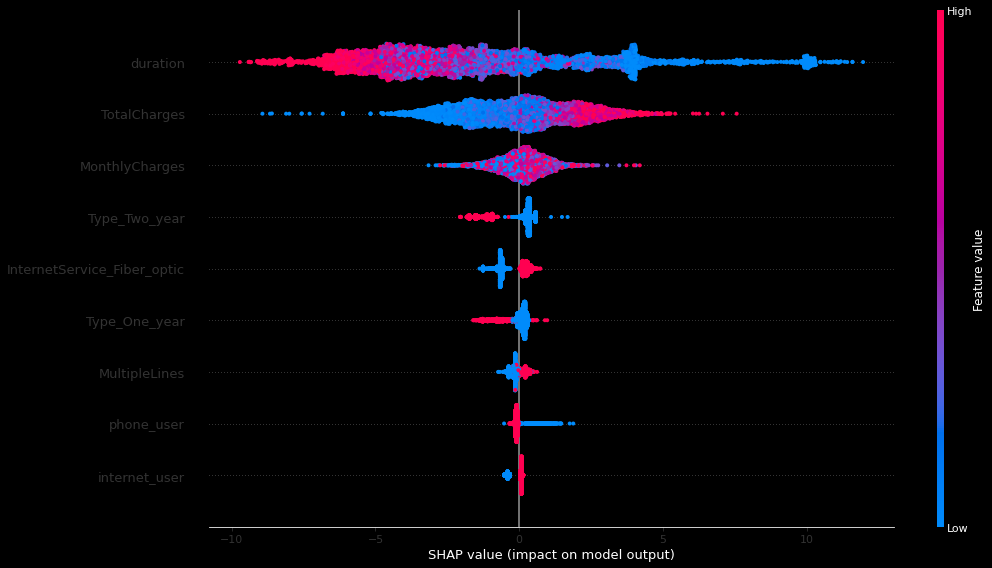

In [ ]:
model_cb = CatBoostClassifier(**params_cb, verbose=False)
model_cb.fit(train_cb[X_cb], train_cb[y])

shap_plot(model_cb, train_cb, X_cb)

Из рисунка видно, что на определение положительного класса и склонности клиента к оттоку влияют:
- малые значения длительности контрактов (`duration`);
- большие итоговые выплаты по контракту (`TotalCharges`) и малые ежемесячные выплаты (`MonthlyCharges`);
- отсутствие двухлетних или однолетних контрактов (`Type_Two_year`, `Type_One_year`);
- подключение интернета по оптоволоконному каналу связи (`InternetService_Fiber_optic`) и наличие самого интернета (`internet_user`);
- отсутствие подключения телефона (`phone_user`) и наличие многоканального телефона (`Multiplelines`).

Разработанная модель достаточно хорошо обрабатывает категориальные признаки и определяет вклад каждой категории в значение целевого признака.
В то же время числовые признаки имеют менее однозначную интерпретацию, в связи с чем представляется целесообразным для увеличения целевой метрики ввести их разбиение на интервалы и преобразование в категориальные признаки.
Рассмотрим эффективность предложенного метода.

In [ ]:
def feature_categorizator(feature_name):

    # Разбиваем на 5 квантилей

    _, categories = pd.qcut(train[f"{feature_name}"], 5, retbins=True)

    # Замена крайних значений категорий бесконечностями

    categories[-1] = float("inf")
    categories[0] = -float("inf")

    # Возвращаем столбцы в трейне и тесте

    return pd.cut(train[f"{feature_name}"], categories).astype("str"), pd.cut(
        test[f"{feature_name}"], categories
    ).astype("str")

In [ ]:
train_cb["MonthlyCharges_cat"], test_cb["MonthlyCharges_cat"] = feature_categorizator(
    "MonthlyCharges"
)
train_cb["TotalCharges_cat"], test_cb["TotalCharges_cat"] = feature_categorizator(
    "MonthlyCharges"
)

cat_features_cb = ["MonthlyCharges_cat", "TotalCharges_cat"]

X_cb = X_cb + cat_features_cb

train_cb, test_cb = ohe(
    train_cb[X_cb + y],
    test_cb[X_cb + y],
    cat_features_cb,
)

Проверим выполненные преобразования.

In [ ]:
train_cb.head()

duration  InternetService_Fiber_optic  Type_Two_year  \
customerID                                                         
3785-NRHYR -1.275778                          0.0            0.0   
3237-AJGEH -1.194397                          0.0            0.0   
9318-NKNFC -1.277112                          0.0            0.0   
3966-HRMZA -1.194397                          1.0            0.0   
3908-MKIMJ  1.445800                          0.0            1.0   

            Type_One_year  TotalCharges  internet_user  phone_user  \
customerID                                                           
3785-NRHYR            0.0     -0.999459              0           1   
3237-AJGEH            0.0     -0.966307              1           0   
9318-NKNFC            0.0     -0.999811              0           1   
3966-HRMZA            0.0     -0.918887              1           1   
3908-MKIMJ            0.0      0.295886              1           0   

            MultipleLines  MonthlyCharges  churn  \
customerID                                         
3785-NRHYR              0       -1.513408      0   
3237-AJGEH              0       -1.134598      1   
9318-NKNFC              0       -1.540108      1   
3966-HRMZA              0        0.335585      0   
3908-MKIMJ              0       -0.769138      0   

            MonthlyCharges_cat_(25.1,_59.5]  MonthlyCharges_cat_(59.5,_79.2]  \
customerID                                                                     
3785-NRHYR                              0.0                              0.0   
3237-AJGEH                              1.0                              0.0   
9318-NKNFC                              0.0                              0.0   
3966-HRMZA                              0.0                              1.0   
3908-MKIMJ                              1.0                              0.0   

            MonthlyCharges_cat_(79.2,_94.1]  MonthlyCharges_cat_(94.1,_inf]  \
customerID                                                                    
3785-NRHYR                              0.0                             0.0   
3237-AJGEH                              0.0                             0.0   
9318-NKNFC                              0.0                             0.0   
3966-HRMZA                              0.0                             0.0   
3908-MKIMJ                              0.0                             0.0   

            TotalCharges_cat_(25.1,_59.5]  TotalCharges_cat_(59.5,_79.2]  \
customerID                                                                 
3785-NRHYR                            0.0                            0.0   
3237-AJGEH                            1.0                            0.0   
9318-NKNFC                            0.0                            0.0   
3966-HRMZA                            0.0                            1.0   
3908-MKIMJ                            1.0                            0.0   

            TotalCharges_cat_(79.2,_94.1]  TotalCharges_cat_(94.1,_inf]  
customerID                                                               
3785-NRHYR                            0.0                           0.0  
3237-AJGEH                            0.0                           0.0  
9318-NKNFC                            0.0                           0.0  
3966-HRMZA                            0.0                           0.0  
3908-MKIMJ                            0.0                           0.0

Таблица соответствует ожиданиям.  
На основании ее столбцов обновим список признаков.

In [ ]:
X_cb = train_cb.drop(y + ["MonthlyCharges", "TotalCharges"], axis=1).columns.tolist()

In [ ]:
X_cb

['duration',
 'InternetService_Fiber_optic',
 'Type_Two_year',
 'Type_One_year',
 'internet_user',
 'phone_user',
 'MultipleLines',
 'MonthlyCharges_cat_(25.1,_59.5]',
 'MonthlyCharges_cat_(59.5,_79.2]',
 'MonthlyCharges_cat_(79.2,_94.1]',
 'MonthlyCharges_cat_(94.1,_inf]',
 'TotalCharges_cat_(25.1,_59.5]',
 'TotalCharges_cat_(59.5,_79.2]',
 'TotalCharges_cat_(79.2,_94.1]',
 'TotalCharges_cat_(94.1,_inf]']

In [ ]:
%%time

study_cb.optimize(objective_cb, n_trials=15, show_progress_bar=True)

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2022-10-24 22:39:31,885] Trial 1 finished with value: 0.9331995057626088 and parameters: {'learning_rate': 0.1228656860634749, 'depth': 7, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.9331995057626088.
[I 2022-10-24 22:40:17,152] Trial 2 finished with value: 0.9210431723960817 and parameters: {'learning_rate': 0.8958038964956513, 'depth': 9, 'min_data_in_leaf': 8}. Best is trial 1 with value: 0.9331995057626088.
[I 2022-10-24 22:40:33,190] Trial 3 finished with value: 0.9299079381312272 and parameters: {'learning_rate': 0.5272159606849095, 'depth': 6, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.9331995057626088.
[I 2022-10-24 22:40:50,660] Trial 4 finished with value: 0.9374966735281631 and parameters: {'learning_rate': 0.1157350896064277, 'depth': 6, 'min_data_in_leaf': 2}. Best is trial 4 with value: 0.9374966735281631.
[I 2022-10-24 22:41:01,907] Trial 5 finished with value: 0.9453634534903224 and parameters: {'learning_rate': 0.3155803175997291, 'depth': 3, 'm

In [ ]:
params_cb_cat = {
    **study_cb.best_params,
    "eval_metric": "Logloss",
    "loss_function": "Logloss",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
    "auto_class_weights": "Balanced",
}

cb_metrics(params_cb_cat, X_cb)

0.9464334833384871

Введение категоризации позволило улучшить метрику на 2,2%.

## Проверка на тестовой выборке

Проведем проверку разработанной модели на тестовой выборке.

In [ ]:
model_cb.fit(train_cb[X_cb], train_cb[y])

roc_auc_score(
    test_cb[y],
    model_cb.predict(test_cb[X_cb], prediction_type="Probability")[:, 1],
)

0.9387926155638444

Модель обладает значением метрики - 0,939.
Таким образом, она обладает переобучением менее чем на 0,7%.

# Выводы

В ходе выполнения работы проведен обзор данных, в результате которого определены проблемы, связанные со способами их хранения.
Для их устранения проведено объединение данных в один датафрейм, обработка категориальных значений, исправление типа хранения данных, а также добавлен целевой признак и признак о длительности контракта.

Анализ самих данных показал, что все признаки обладают высокой корреляцией как с целевым признаком, так и между собой.
В этой связи проведена их оптимизация по указанному критерию.
Оптимизация количества признаков в процессе моделирования выявила наиболее зашумленные из них и позволила сократить количество.

В результате проведенных работ получено, что метрика ROC AUC на тестовой выборке принимает максимальные значения 0,939 при пороге в 0,88 при использовании модели CatBoost.

Анализ построенной модели показал, что на определение положительного класса и склонности клиента к оттоку влияют:
- малые значения длительности контрактов (`duration`);
- большие итоговые выплаты по контракту (`TotalCharges`) и малые ежемесяцчные выплаты (`MonthlyCharges`);
- отсутствие двухлетних или однолетних контрактов контрактов (`Type_Two_year`, `Type_One_year`);
- подключение интернета по оптоволоконному каналу связи (`InternetService_Fiber_optic`) и наличие самого интернета (`internet_user`);
- отсутствие подключения телефона (`phone_user`) и наличие многоканального телефона (`Multiplelines`).